# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.745814,True,6.922475
1,-1.178830,True,1.690752
2,1.431169,True,5.885909
3,1.856767,True,10.053184
4,0.964339,True,6.953093
...,...,...,...
995,0.570637,False,2.470646
996,1.496082,False,2.511838
997,2.776382,True,11.098870
998,0.646236,False,0.813353


<Axes: xlabel='v0'>

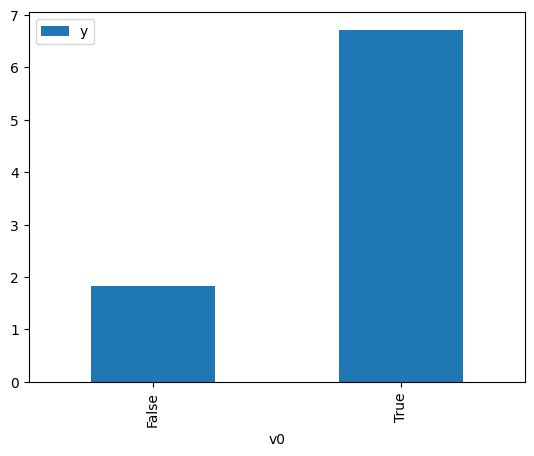

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

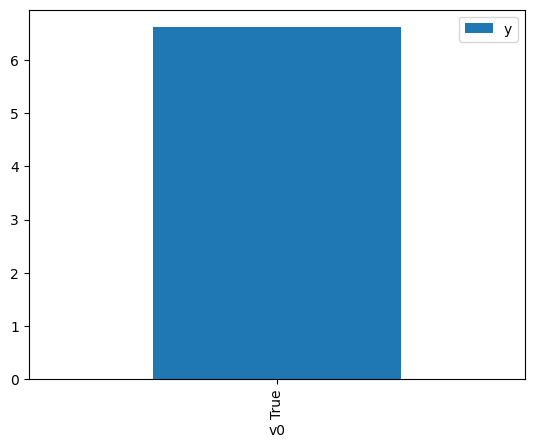

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.816995,False,3.041536,0.381394,2.621962
1,1.042252,False,1.759330,0.362183,2.761037
2,0.765792,False,0.756403,0.385815,2.591913
3,1.660931,False,3.531442,0.311771,3.207480
4,0.934917,False,2.267955,0.371286,2.693340
...,...,...,...,...,...
995,-0.032777,False,-0.173845,0.456786,2.189211
996,1.714121,False,3.972089,0.307618,3.250780
997,2.025042,False,4.671928,0.283975,3.521436
998,0.956879,False,0.992560,0.369416,2.706977


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.473327,True,7.012360,0.588586,1.698986
1,1.437784,True,6.290172,0.670480,1.491469
2,0.822568,True,6.082444,0.619086,1.615284
3,1.282197,True,6.879967,0.657806,1.520204
4,-1.090186,True,3.892528,0.446978,2.237246
...,...,...,...,...,...
995,1.269583,True,7.496778,0.656769,1.522606
996,0.321939,True,6.200527,0.575136,1.738720
997,-0.790783,True,2.830410,0.474138,2.109093
998,0.059997,True,5.736890,0.551609,1.812880


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.616e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        17:20:09   Log-Likelihood:                         -1435.6
No. Observations:                1000   AIC:                                      2875.
Df Residuals:                     998   BIC:                                      2885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0192      0.031     64.897      0.000       1.958       2.080
x2             4.9989      0.050     99.324      0.000       4.900       5.098
==============================================================================
Omnibus:                        2.227   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                2.273
Skew:                           0.027   Prob(JB):                        0.321
Kurtosis:                       3.227   Cond. No.                         2.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""